<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Decision Tree   
<font color=black size=4>
    Hamidreza Yaghoubi 
    
<br><br>
<font size=4>
In this homework, we are going to implement the Classification Decision Tree. Keep in mind to complete all of the following questions and write your own codes in the TODO cells.

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 2: Classification Decision Tree (100 points)
We will implement a Classification Decision Tree from scratch in the following problem. Then we will use our model to predict malignant and benign breast cancer. For this purpose, we will use the breast_cancer.csv dataset which you can find more details about it <a href="https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset"><font face="Roboto">here</font></a>.

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from math import log
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<font face="Times New Roman" size=4><div dir=ltr>
## Classification Decision Tree Class (60 points)
In this section, you only need to fill TODO parts. You can find the logic and formula in both course slides and the web, but fill it out on your own. 

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

In [15]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def is_splitting_finished(self, depth, num_class_labels, num_samples):
        return depth >= self.max_depth \
            or num_class_labels == 1 \
            or num_samples <= self.min_samples_split

    def split(self, X, y, feature, threshold):
        left_indexes = X[feature] <= threshold
        right_indexes = -left_indexes
        X_left = X[left_indexes]
        y_left = y[left_indexes]
        X_right = X[right_indexes]
        y_right = y[right_indexes]

        return X_left, X_right, y_left, y_right

    def entropy(self, y):
        p = len(y[y == 1]) / len(y)
        if p == 1 or p == 0:
            return 0
        ent1 = -p * log(p, 2) - (1 - p) * log(1 - p, 2)
        probs = np.bincount(y) / len(y)
        ent = -np.sum([p * np.log2(p) for p in probs if p > 0])
        return ent

    def information_gain(self, X, y, feature, threshold):
        X_left, X_right, y_left, y_right = self.split(X, y, feature, threshold)
        H_y = self.entropy(y)
        n, n_left, n_right = len(y), len(y_left), len(y_right)
        if n_left == 0 or n_right == 0:
            return 0
        H_y_given_x = (n_left / n) * self.entropy(y_left) + (n_right / n) * self.entropy(y_right)
        ig = H_y - H_y_given_x
        return ig

    def best_split(self, X, y):
        best_score = -1
        best_feature = None
        best_threshold = None
        features = list(X.columns.values)
        random.shuffle(features)
        
        for feat in features:
            X_feat = X[feat]
            thresholds = np.unique(X_feat)
            for thresh in thresholds:
                score = self.information_gain(X, y, feat, thresh)
                if score > best_score:
                    best_score = score
                    best_feature = feat
                    best_threshold = thresh

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_class_labels = len(np.unique(y))
        if self.is_splitting_finished(depth, n_class_labels, n_samples):
            return None
#         if self.is_splitting_finished(depth, len(X.columns), len(X)):
#             return None

        best_feature, best_threshold = self.best_split(X, y)
        X_left, X_right, y_left, y_right = self.split(X, y, best_feature, best_threshold)

        left_node = self.build_tree(X_left, y_left, depth=depth + 1)
        right_node = self.build_tree(X_right, y_right, depth=depth + 1)

        value = None
        if left_node is None or right_node is None:
#             true_value = len(y[y['diagnosis'] == 1])
#             false_value = len(y[y['diagnosis'] == 0])
            true_value = len(y[y == 1])
            false_value = len(y[y == 0])
            if true_value >= false_value:
                value = 1
            else:
                value = 0

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node, value=value)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict(self, X):
        tree = self.root
        predicted_value = []
        for index in list(X.index):
            data = X.loc[index]
            current_tree = tree
            for depth in range(self.max_depth):
                if Node.is_leaf(current_tree):
                    predicted_value.append(current_tree.value)
                    break
                feature = current_tree.feature
                threshold = current_tree.threshold
                if data[feature] <= threshold:
                    current_tree = current_tree.left
                if data[feature] > threshold:
                    current_tree = current_tree.right

        return predicted_value

<font face="Times New Roman" size=4><div dir=ltr>
## Data Prepration (20 points)
In this section, you must perform a good EDA for data. Then split it into train and validation data. We will then use the validation data to find the best model hyperparameters.  

In [4]:
breast_cancer_pdf = pd.read_csv("breast_cancer.csv")

In [5]:
breast_cancer_pdf.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [6]:
breast_cancer_pdf.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

In [7]:
breast_cancer_pdf.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


In [8]:
for column in breast_cancer_pdf.columns:
    print(breast_cancer_pdf[column].value_counts())  

12.34    4
11.71    3
12.46    3
13.05    3
10.26    3
        ..
12.23    1
14.45    1
19.18    1
18.08    1
7.76     1
Name: mean_radius, Length: 456, dtype: int64
20.52    3
16.85    3
16.84    3
19.83    3
14.93    3
        ..
18.58    1
15.11    1
22.41    1
14.92    1
24.54    1
Name: mean_texture, Length: 479, dtype: int64
82.61     3
87.76     3
134.70    3
93.97     2
82.69     2
         ..
127.50    1
90.63     1
82.53     1
100.40    1
47.92     1
Name: mean_perimeter, Length: 522, dtype: int64
512.2     3
1075.0    2
582.7     2
399.8     2
641.2     2
         ..
507.4     1
609.9     1
463.7     1
428.9     1
181.0     1
Name: mean_area, Length: 539, dtype: int64
0.10070    5
0.11500    4
0.10540    4
0.10750    4
0.10630    3
          ..
0.08876    1
0.09965    1
0.13230    1
0.08968    1
0.05263    1
Name: mean_smoothness, Length: 474, dtype: int64
1    357
0    212
Name: diagnosis, dtype: int64


<AxesSubplot:>

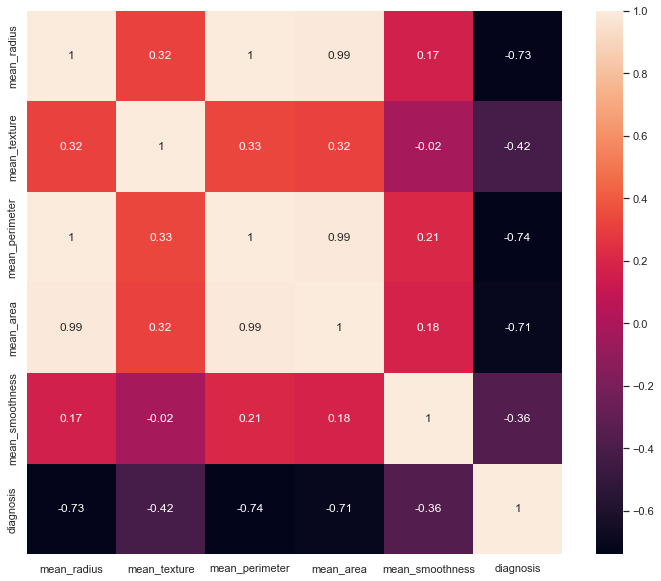

In [9]:
correlation_matrix = breast_cancer_pdf.corr().round(2)

sns.set(rc={'figure.figsize':(12, 10)})
sns.heatmap(data=correlation_matrix, annot=True)

In [10]:
def multiple_plot(df, y, features, n_row=3, n_col=4):
    """
    Helper function to plot multiple plots
    """
    assert len(features) <= n_row * n_col
    plt.figure(figsize=(2 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        if i >= len(features):
            return
        col = features[i]
        x = df[col]
        plt.subplot(n_row, n_col, i + 1)
        plt.scatter(x, y, marker='o')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('diagnosis')
        plt.xticks(())
        plt.yticks(())

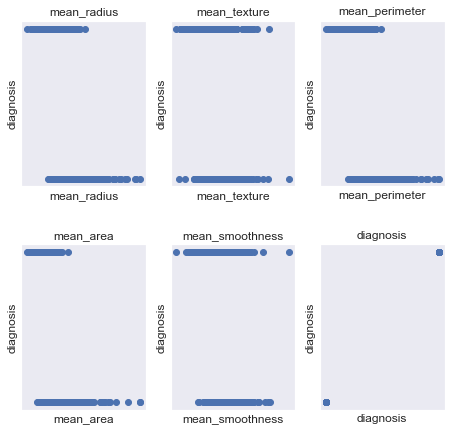

In [11]:
features = breast_cancer_pdf.columns.values
target = breast_cancer_pdf['diagnosis']

multiple_plot(breast_cancer_pdf, target, features, 2, 3)

In [12]:
X = breast_cancer_pdf.drop('diagnosis', axis=1)
y = breast_cancer_pdf['diagnosis']

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
## Training And Tuning Hyperparameters (20 points)
In this section, you only need to find the best hyperparameters for your model. You can test different values and permutations of hyperparameters by adding them to the lists below. Your model must have at least accuracy=0.85 on validation data.

In [13]:
max_depths = [3, 5, 10, 20]
min_samples_splits = [5, 10, 20, 50]

In [16]:
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0
best_model = None
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        clf = DecisionTree(max_depth, min_samples_split)
        clf.fit(x_train, y_train)
        y_val_pred = clf.predict(x_val)
        y_train_pred = clf.predict(x_train)
        accuracy = accuracy_score(y_val_pred, y_val)
        train_accuracy = accuracy_score(y_train_pred, y_train)
        print(f"accuracy of training set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={train_accuracy}")
        print(f"accuracy of validation set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={accuracy}")
        print("------------------------------------------------")
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_model = clf

accuracy of training set for [min_samples_splits=5-max_depths=3] =0.8844221105527639
accuracy of validation set for [min_samples_splits=5-max_depths=3] =0.8888888888888888
------------------------------------------------
accuracy of training set for [min_samples_splits=10-max_depths=3] =0.8844221105527639
accuracy of validation set for [min_samples_splits=10-max_depths=3] =0.8888888888888888
------------------------------------------------
accuracy of training set for [min_samples_splits=20-max_depths=3] =0.8819095477386935
accuracy of validation set for [min_samples_splits=20-max_depths=3] =0.9064327485380117
------------------------------------------------
accuracy of training set for [min_samples_splits=50-max_depths=3] =0.8819095477386935
accuracy of validation set for [min_samples_splits=50-max_depths=3] =0.9064327485380117
------------------------------------------------
accuracy of training set for [min_samples_splits=5-max_depths=5] =0.8844221105527639
accuracy of validation se

In [17]:
print(
    f'best_accuracy = {best_accuracy}', 
    f'best_max_depth = {best_max_depth}',
    f'best_min_samples_split = {best_min_samples_split}',
    sep='\n'
)

best_accuracy = 0.9064327485380117
best_max_depth = 20
best_min_samples_split = 50


In [18]:
import pickle

with open('decision_tree.pickle', 'wb') as f:
    pickle.dump(best_model, f)